# **Senior Design Project - Brain Machine Interface**



### Krithik Parvataneni, Lisa Verma, Tsenbujin Tsendjav, Wencan Yang



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_to_mat = '/content/drive/Shared drives/EEC174AY Group 8/Dataset/mat_data'
path_to_txt = '/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data'
path_to_model = '/content/drive/Shared drives/EEC174AY Group 8/models/'

## **All imports used**

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pandas as pd
import gc
import torch.utils.data as data
import torchvision.datasets as datasets
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import Input
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import keras

## **Load the dataset**

## **Data preprocessing**
### **Data loader:**

In [ ]:
class DataSet(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [file.path for file in os.scandir(self.root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        mat_data = sio.loadmat(file_path)

        all_data = []
        all_data.append(mat_data)

        return all_data

In [ ]:
# 32 channels
class get_data():

    def __init__(self, mat_input, device):
        self.mat_input = mat_input
        self.device = device

    def get_movement(self, channels=None):
        movement_left = []
        movement_right = []
        movement_event = []
        sliced_left = []
        sliced_right = []
        index = []
        movement_event = self.mat_input['eeg']['movement_event'][0][0][0]
        if channels == None:
          channels = [0, 33, 36, 6, 4, 37, 39, 41, 46, 10, 12, 49, 51, 14, 18, 55, 16, 53, 22, 20, 30, 57, 59, 26, 28, 63, 11, 44, 48, 8, 46, 55]
        # get raw dataset
        for i in channels:
            movement_left.append(self.mat_input['eeg']['movement_left'][0][0][i])
            movement_right.append(self.mat_input['eeg']['movement_right'][0][0][i])
        #get onset (starting pt) of movement_event:
        for q in range(len(movement_event)):
            if movement_event[q] == 1:
                  index.append(q)
        #slice movement_left and right to only keep active region:
        for x in range(len(index)):
            temp_left = []
            temp_right = []
            for j in range(len(movement_left)):
                start_index = index[x]
                end_index = start_index + 1536 #three seconds for a period
                temp_left.append(movement_left[j][start_index:end_index])
                temp_right.append(movement_right[j][start_index:end_index])
            sliced_left.append(temp_left)
            sliced_right.append(temp_right)

        sliced_left_tensor = torch.tensor(np.array(sliced_left), device=self.device)
        sliced_right_tensor = torch.tensor(np.array(sliced_right), device=self.device)
        index_tensor = torch.tensor(np.array(index), device=self.device)

        return sliced_left_tensor, index_tensor, sliced_right_tensor

In [ ]:
mat_data = DataSet(path_to_mat)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

move_left = []
move_right = []
move_idx = []
for subject in range(len(mat_data)):
  left = []
  right = []
  index = []
  left, idx, right = get_data(mat_data[subject][0], device).get_movement()
  move_left.append(left)
  move_right.append(right)
  move_idx.append(idx)

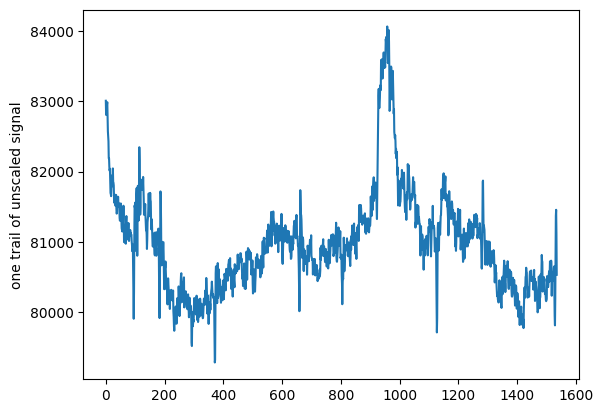

In [ ]:
move_left_cpu = move_left[20][1][7].cpu()
# Convert tensor to numpy array
left_numpy = move_left_cpu.detach().numpy()

plt.plot(left_numpy)
plt.ylabel('one trial of unscaled signal')
plt.show()

In [ ]:
def filter(input_tensor, window_size):
    total = []
    window = window_size
    new_length = 0
    for i in range(input_tensor.size(0)):
        one_trail = []
        for k in range(input_tensor.size(1)):
            one_channel = []
            for y in range(input_tensor.size(2)):
                if y >= window:
                    # Use PyTorch operations for efficiency
                    window_slice = input_tensor[i, k, y-window:y]
                    avg = torch.mean(window_slice)
                    one_channel.append(avg.item())  # Convert back to Python scalar
            one_trail.append(one_channel)
            new_length = len(one_channel)
        total.append(one_trail)

    total_tensor = torch.tensor(total, dtype=input_tensor.dtype, device=input_tensor.device)
    return total_tensor, new_length

move_right_filtered = []
move_left_filtered = []
new_timesteps = []

for subject in range(len(move_left)):
    left_filtered, timesteps = filter(move_left[subject], 32)
    move_left_filtered.append(left_filtered)

for subject in range(len(move_right)):
    right_filtered, timesteps = filter(move_right[subject], 32)
    move_right_filtered.append(right_filtered)

<ipython-input-13-b49298ee1aa1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  move_left_cpu_filtered = torch.tensor(move_left_filtered[20][1][7]).cpu()


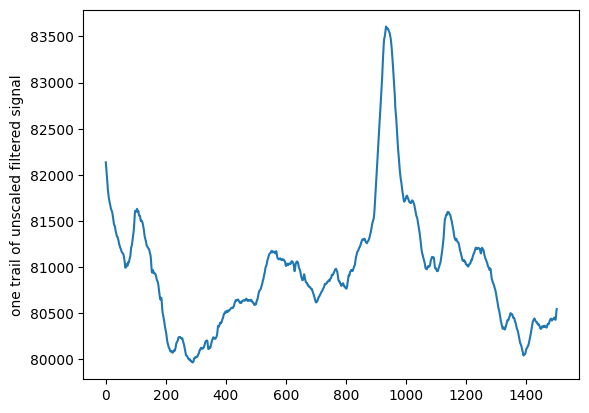

In [ ]:
move_left_cpu_filtered = torch.tensor(move_left_filtered[20][1][7]).cpu()

plt.plot(move_left_cpu_filtered)
plt.ylabel('one trial of unscaled filtered signal')
plt.show()

In [ ]:
def reshape(input_tensor):
    output_tensor = []
    for i in range(input_tensor.size(0)):
        each_trail = []
        before_trans = input_tensor[i].cpu().detach().numpy()
        transposed_tensor = torch.tensor(before_trans.transpose(), dtype=input_tensor.dtype, device=input_tensor.device)
        output_tensor.append(transposed_tensor)
    return output_tensor

In [ ]:
move_right_reshaped = []
move_left_reshaped = []

for subject in range(len(move_left_filtered)):
    left_reshaped = reshape(move_left_filtered[subject])
    move_left_reshaped.append(left_reshaped)

for subject in range(len(move_right_filtered)):
    right_reshaped = reshape(move_right_filtered[subject])
    move_right_reshaped.append(right_reshaped)

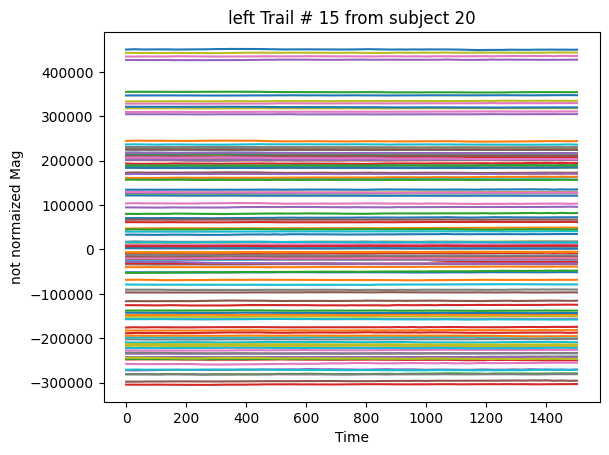

In [ ]:
trail01 = move_left_reshaped[19][0].cpu()
trail05 = move_left_reshaped[19][4].cpu()
trail10 = move_left_reshaped[19][9].cpu()
trail15 = move_left_reshaped[19][14].cpu()
plt.plot(trail01)
plt.title('Left Trial # 1 from subject 20')
plt.xlabel('Time')
plt.ylabel('non normaized Mag')
# plt.show()
plt.plot(trail05)
plt.title('Left Trial # 5 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
# plt.show()
plt.plot(trail10)
plt.title('Left Trial # 10 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
# plt.show()
plt.plot(trail15)
plt.title('Left Trial # 15 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
plt.show()

In [ ]:
def normalize(input_data):
    output_tensor = []
    device = input_data[0].device
    for i in range(len(input_data)):
        scaler = StandardScaler()
        numpy_data = input_data[i].cpu().detach().numpy()
        scaler.fit(numpy_data)
        scaled_data = torch.tensor(scaler.transform(numpy_data), device=device)
        output_tensor.append(scaled_data)
    return output_tensor

In [ ]:
move_right_normalized = []
move_left_normalized = []

for subject in range(len(move_left_reshaped)):
    left_normalized = normalize(move_left_reshaped[subject])
    move_left_normalized.append(left_normalized)

for subject in range(len(move_right_reshaped)):
    right_normalized = normalize(move_right_reshaped[subject])
    move_right_normalized.append(right_normalized)

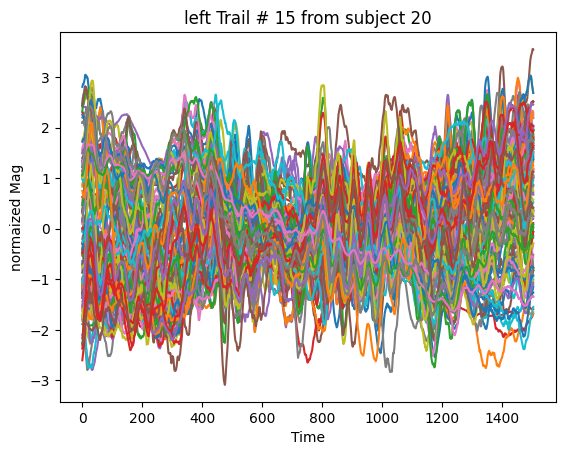

In [ ]:
ntrail01 = move_left_normalized[19][0].cpu()
ntrail05 = move_left_normalized[19][4].cpu()
ntrail10 = move_left_normalized[19][9].cpu()
ntrail15 = move_left_normalized[19][14].cpu()
plt.plot(ntrail01)
plt.title('Left Trial # 1 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail05)
plt.title('Left Trial # 5 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail10)
plt.title('Left Trial # 10 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail15)
plt.title('Left Trial # 15 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
plt.show()

In [ ]:
label = []
X = []
for i in range(len(move_left_normalized)):
    label.append([0]) # left - class 0
    X.append(move_left_normalized[i])
for y in range(len(move_right_normalized)):
    label.append([1]) # right - class 1
    X.append(move_right_normalized[y])

#shuffle arrays for randomness:
import random
temp = list(zip(X, label))
random.shuffle(temp)
X, label = zip(*temp)

print(len(X))
print(len(label))

104
104


Transfer into numpy array

In [ ]:
label = np.array(label)
X = np.array([item[0].cpu().detach().numpy() for item in X])
X[0][0]

array([-0.49758482, -0.32527238, -1.1261313 , -0.38350275, -1.9690937 ,
       -1.5536379 , -1.3537912 , -0.90885174, -0.58821416, -1.2074379 ,
       -1.12005   , -1.3925173 , -1.3248135 , -1.3240061 ,  0.56377655,
        0.69004   , -0.4312352 ,  1.5021077 ,  1.0225558 , -2.3435268 ,
       -1.7151808 ,  0.7261107 ,  0.52464473, -0.8471996 ,  0.43376273,
        1.5409003 , -1.1710106 , -2.286846  , -1.6717435 , -0.53723633,
       -0.58821416,  0.69004   ], dtype=float32)

In [ ]:
import math as math
element_num = len(X)
train_index = element_num * 0.8 #choose 80% for training and 20% for validation
train_index = math.floor(train_index)
scaled_X = np.array(normalize(torch.tensor(X)))
train_X = scaled_X[:train_index]
train_label = label[:train_index]
test_X = scaled_X[train_index:]
test_label = label[train_index:]

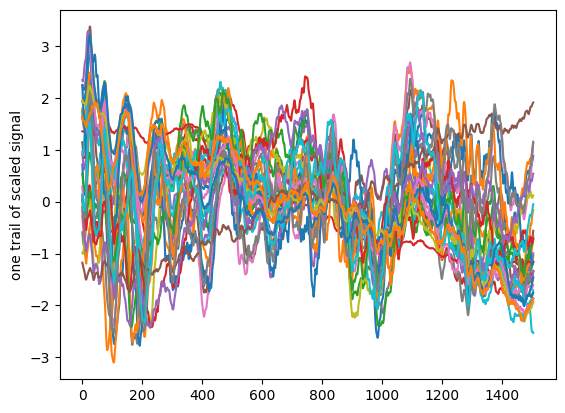

In [ ]:
plt.plot(scaled_X[8])
plt.ylabel('one trial of scaled signal')
plt.show()

### **Build the neural network**
#### **K-fold Cross Validation**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input
import keras
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=seed)
cvscores = []
# code for building an LSTM with 100 neurons and dropout. Runs for 50 epochs
time_steps = new_timesteps
n_features = 32

device = '/gpu:0'
for train, test in kfold.split(X, label):

    # val_data = (X[test], label[test])
    with tf.device(device):
      model = Sequential()
      model.add(Conv1D(filters=200,
                      kernel_size=75,
                      strides=1,
                      activation='relu',
                      padding='same'))
      model.add(Dropout(0.5))
      model.add(Conv1D(filters=200,
                      kernel_size=75,
                      strides=1,
                      activation='relu',
                      padding='same'))
      model.add(Dropout(0.4))
      model.add(MaxPooling1D(4))
      model.add(Conv1D(75, 75, activation='relu'))
      # model.add(Conv1D(160, 100, activation='relu'))
      model.add(GlobalAveragePooling1D())
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      sgd = keras.optimizers.SGD(0.002, 0.9, False)
      model.compile(loss='binary_crossentropy',
                    optimizer=sgd,
                    metrics=['accuracy'])
      rnn = model.fit(X[train], label[train], batch_size=16, epochs=50, verbose=0)
      scores = model.evaluate(X[test], label[test], verbose=0)
      print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
      cvscores.append(scores[1] * 100)
print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

accuracy: 53.85%
accuracy: 69.23%
accuracy: 69.23%
accuracy: 30.77%


accuracy: 53.85%


accuracy: 61.54%
accuracy: 61.54%
accuracy: 53.85%
56.73% (+/- 11.50%)


## **Model Import**
### **LSTM**

In [ ]:

from keras.callbacks import Callback
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
        self.val_losses = []
        self.val_accs = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import Input
import warnings
warnings.filterwarnings('ignore')

# code for building an LSTM with 100 neurons and dropout. Runs for 50 epochs
time_steps = 1504
n_features = 32
device = '/gpu:0'
# write validation data into a tuple:
val_data = (test_X, test_label)
with tf.device(device):
  model = Sequential()
  model.add(Conv1D(filters=32,
                   kernel_size=32,
                   strides=1,
                   activation='relu',
                   padding='same',
                   input_shape=(time_steps, n_features)))
  model.add(LSTM(75, return_sequences=True, input_shape=(time_steps, n_features)))
  model.add(Dropout(0.2))
  model.add(LSTM(75, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(1, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  sgd = keras.optimizers.SGD(0.002, 0.9, False)
  model.summary()
  model.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
  history = LossAccHistory()
  rnn = model.fit(train_X, train_label, batch_size=128, epochs=50, validation_data=val_data, callbacks=[history])
# score = model.evaluate(test_X, test_label)

history_dict = {
    "Epoch": range(1, len(history.losses) + 1),
    "Train Loss": history.losses,
    "Train Accuracy": history.accs,
    "Validation Loss": history.val_losses,
    "Validation Accuracy": history.val_accs
}


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 1504, 32)          32800     
                                                                 
 lstm (LSTM)                 (None, 1504, 75)          32400     
                                                                 
 dropout_24 (Dropout)        (None, 1504, 75)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1504, 75)          45300     
                                                                 
 dropout_25 (Dropout)        (None, 1504, 75)          0         
                                                                 
 lstm_2 (LSTM)               (None, 1504, 50)          25200     
                                                                 
 dropout_26 (Dropout)        (None, 1504, 50)         

In [ ]:
history_df = pd.DataFrame(history_dict)
display(history_df)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,0.705056,0.542169,0.716674,0.380952
1,2,0.706713,0.530120,0.713010,0.380952
2,3,0.722009,0.457831,0.710170,0.428571
3,4,0.692850,0.566265,0.709401,0.428571
4,5,0.682936,0.590361,0.708117,0.428571
5,6,0.693574,0.542169,0.707358,0.476190
6,7,0.664035,0.602410,0.708171,0.476190
7,8,0.683236,0.566265,0.707958,0.523810
8,9,0.679241,0.566265,0.707717,0.571429
9,10,0.655310,0.602410,0.709044,0.571429


In [ ]:
print('Average Validation Accuracy: %.2f%% (+/- %.2f%%)' % (history_df['Validation Accuracy'].mean() * 100, history_df['Validation Accuracy'].std()*100))

Average Validation Accuracy: 44.19% (+/- 4.62%)


In [ ]:
model.save(os.path.join(path_to_model, 'lstm32.pth'))

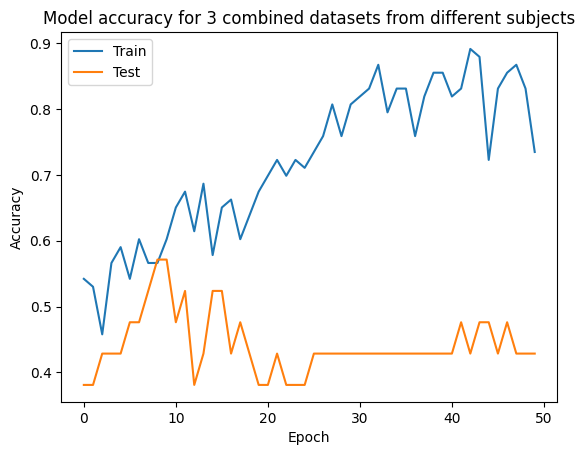

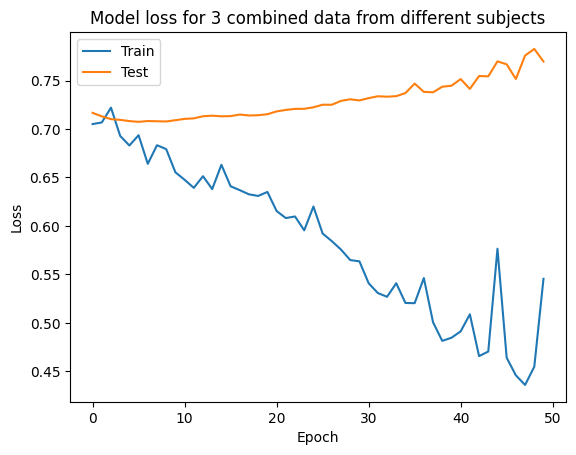

In [ ]:
#Visualize Result
# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### **CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input
import keras
history_dict = {}

time_steps = new_timesteps
# time_steps = 1536
n_features = 4
#write validation data into a tuple:
val_data = (test_X, test_label)
device = '/gpu:0'
with tf.device(device):
  model = Sequential()
  model.add(Conv1D(filters=200, #200 get 0.6955
                  kernel_size=50,
                  strides=1,
                  activation='relu',
                  padding='same'))
  model.add(Dropout(0.6))
  model.add(Conv1D(filters=150,
                  kernel_size=50,
                  strides=1,
                  activation='relu',
                  padding='same'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(4))
  model.add(Conv1D(50, 50, activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  sgd = keras.optimizers.SGD(0.002, 0.9, False)
  model.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
  history = LossAccHistory()
  rnn = model.fit(train_X, train_label, batch_size=128, epochs=50, validation_data=val_data, callbacks=[history])
# score = model.evaluate(test_X, test_label)

history_dict = {
    "Epoch": range(1, len(history.losses) + 1),
    "Train Loss": history.losses,
    "Train Accuracy": history.accs,
    "Validation Loss": history.val_losses,
    "Validation Accuracy": history.val_accs
}

Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 0.7517 - accuracy: 0.5422 - val_loss: 0.6922 - val_accuracy: 0.5714
Epoch 2/50
1/1 [==============================] - 0s 273ms/step - loss: 0.7561 - accuracy: 0.5301 - val_loss: 0.6908 - val_accuracy: 0.5714
Epoch 3/50
1/1 [==============================] - 0s 277ms/step - loss: 0.8172 - accuracy: 0.5301 - val_loss: 0.6894 - val_accuracy: 0.5714
Epoch 4/50
1/1 [==============================] - 0s 269ms/step - loss: 0.9005 - accuracy: 0.4096 - val_loss: 0.6889 - val_accuracy: 0.6190
Epoch 5/50
1/1 [==============================] - 0s 280ms/step - loss: 0.9524 - accuracy: 0.4578 - val_loss: 0.6882 - val_accuracy: 0.6190
Epoch 6/50
1/1 [==============================] - 0s 272ms/step - loss: 0.7358 - accuracy: 0.5301 - val_loss: 0.6877 - val_accuracy: 0.6190
Epoch 7/50
1/1 [==============================] - 0s 272ms/step - loss: 0.6865 - accuracy: 0.5783 - val_loss: 0.6883 - val_accuracy: 0.6190
Epoch 8/50
1/1 [=====

In [ ]:
history_df_cnn = pd.DataFrame(history_dict)
display(history_df_cnn)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,0.751742,0.542169,0.692150,0.571429
1,2,0.756146,0.530120,0.690826,0.571429
2,3,0.817162,0.530120,0.689439,0.571429
3,4,0.900516,0.409639,0.688933,0.619048
4,5,0.952430,0.457831,0.688186,0.619048
5,6,0.735837,0.530120,0.687723,0.619048
6,7,0.686500,0.578313,0.688300,0.619048
7,8,0.768799,0.493976,0.687426,0.619048
8,9,0.756599,0.493976,0.687557,0.619048
9,10,0.843515,0.506024,0.687536,0.619048


In [ ]:
model.save(os.path.join(path_to_model, 'cnn.pth'))

In [ ]:
print('Average Validation Accuracy: %.2f%% (+/- %.2f%%)' % (history_df_cnn['Validation Accuracy'].mean() * 100, history_df_cnn['Validation Accuracy'].std()*100))

Average Validation Accuracy: 59.81% (+/- 2.57%)


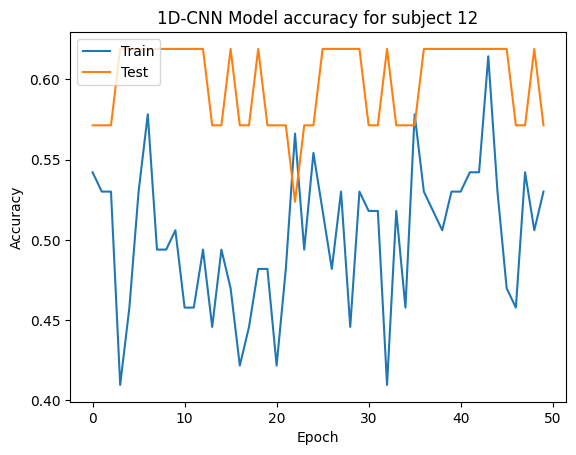

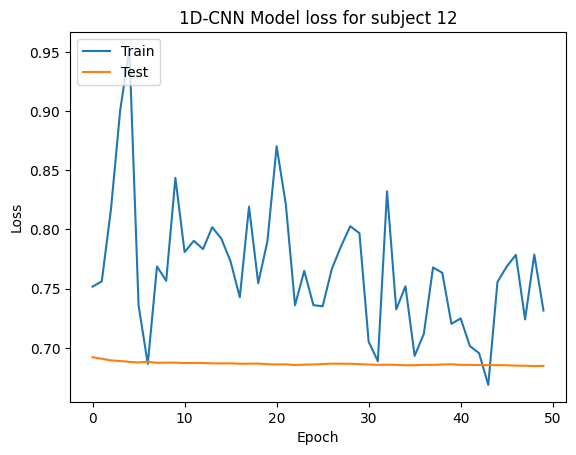

In [ ]:
#Visualize Result
# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('1D-CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('1D-CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### **Visualize the Results**

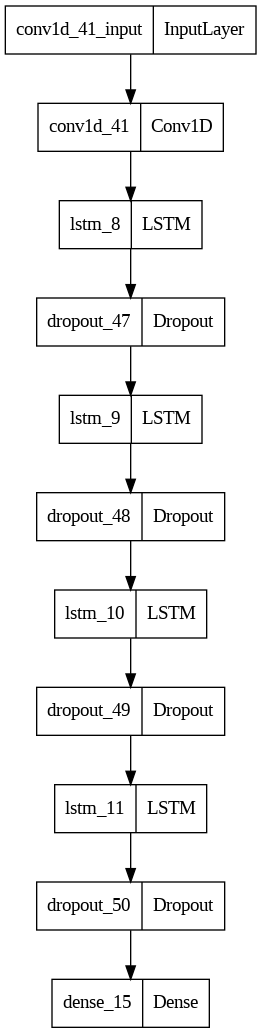

In [ ]:

from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.save(os.path.join(path_to_model, 'lstm32.pth'))